Processing test: 100%|██████████| 6/6 [00:00<00:00, 16.42it/s]


   split    city                                       file     label  \
0  train  aachen  aachen_000000_000019_gtFine_polygons.json      road   
1  train  aachen  aachen_000000_000019_gtFine_polygons.json  sidewalk   
2  train  aachen  aachen_000000_000019_gtFine_polygons.json       car   
3  train  aachen  aachen_000000_000019_gtFine_polygons.json       car   
4  train  aachen  aachen_000000_000019_gtFine_polygons.json       car   

                                             polygon  
0  [[0, 769], [290, 574], [93, 528], [0, 524], [0...  
1  [[2047, 532], [1911, 537], [1828, 540], [1782,...  
2  [[806, 503], [803, 524], [796, 528], [785, 528...  
3  [[281, 430], [196, 429], [181, 436], [172, 444...  
4  [[281, 430], [196, 429], [181, 436], [172, 444...  
label
pole                    52748
static                  47217
car                     31822
traffic sign            24976
person                  21413
vegetation              17745
traffic light           11898
sidewalk       

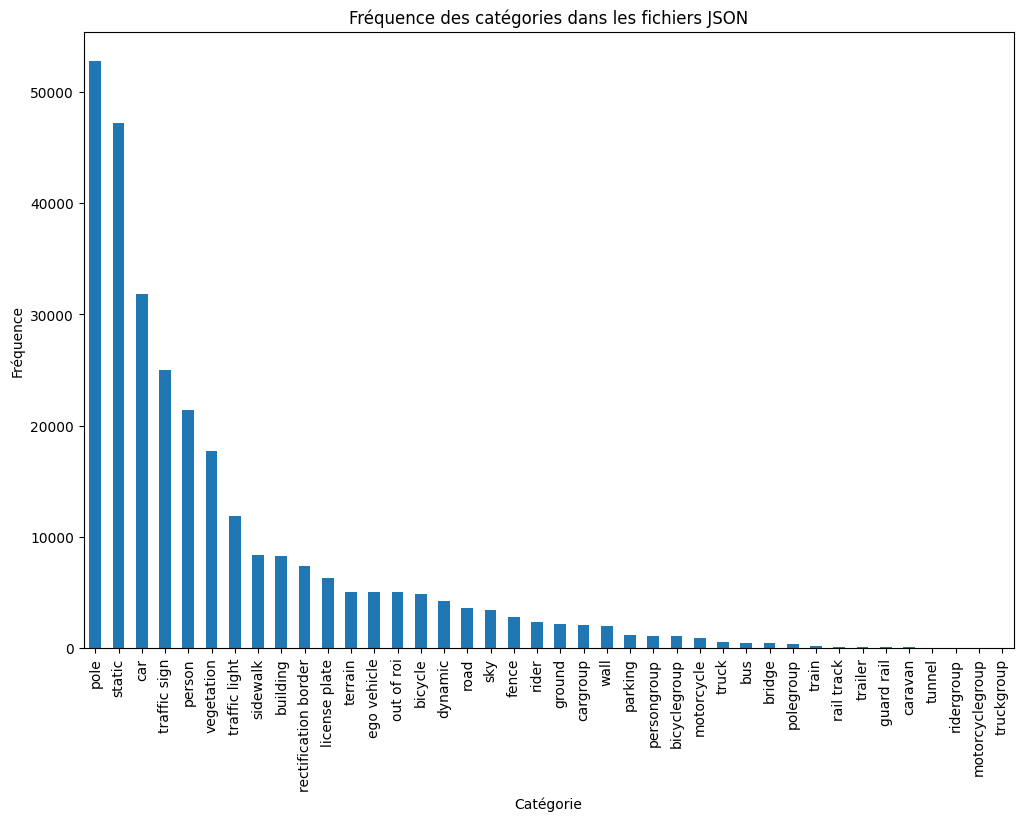

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Définir les chemins
gtfine_dir = './gtfine'

# Extraire les données des fichiers JSON
data = []

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(gtfine_dir, split)
    for city in tqdm(os.listdir(split_dir), desc=f'Processing {split}'):
        city_dir = os.path.join(split_dir, city)
        for file in os.listdir(city_dir):
            if file.endswith('_gtFine_polygons.json'):
                json_path = os.path.join(city_dir, file)
                with open(json_path, 'r') as f:
                    json_data = json.load(f)
                    for obj in json_data['objects']:
                        data.append({
                            'split': split,
                            'city': city,
                            'file': file,
                            'label': obj['label'],
                            'polygon': obj['polygon']
                        })

# Créer un DataFrame à partir des données extraites
df = pd.DataFrame(data)
print(df.head())

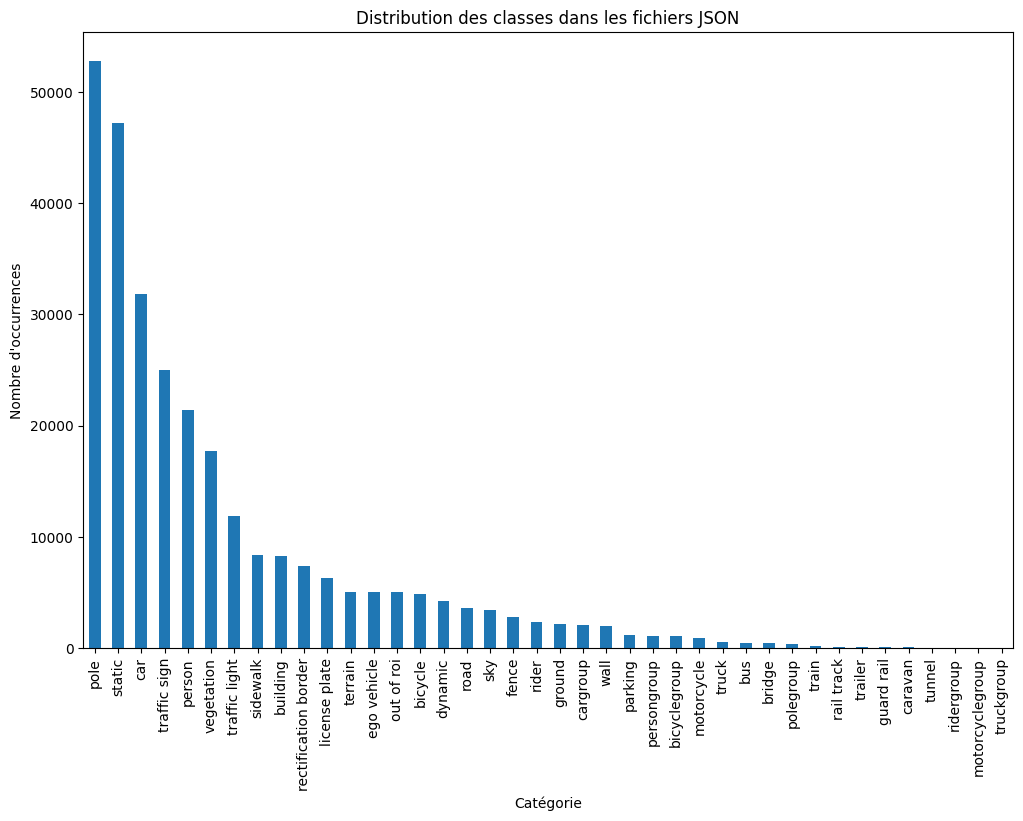

Distribution des classes en pourcentage :
label
pole                    18.349364
static                  16.425304
car                     11.069869
traffic sign             8.688362
person                   7.448907
vegetation               6.172925
traffic light            4.138939
sidewalk                 2.904354
building                 2.887656
rectification border     2.565878
license plate            2.187745
terrain                  1.763693
ego vehicle              1.739342
out of roi               1.739342
bicycle                  1.705947
dynamic                  1.479484
road                     1.257892
sky                      1.190058
fence                    0.987598
rider                    0.822013
ground                   0.748265
cargroup                 0.714870
wall                     0.688432
parking                  0.423008
persongroup              0.371871
bicyclegroup             0.364914
motorcycle               0.308907
truck                    0.202459


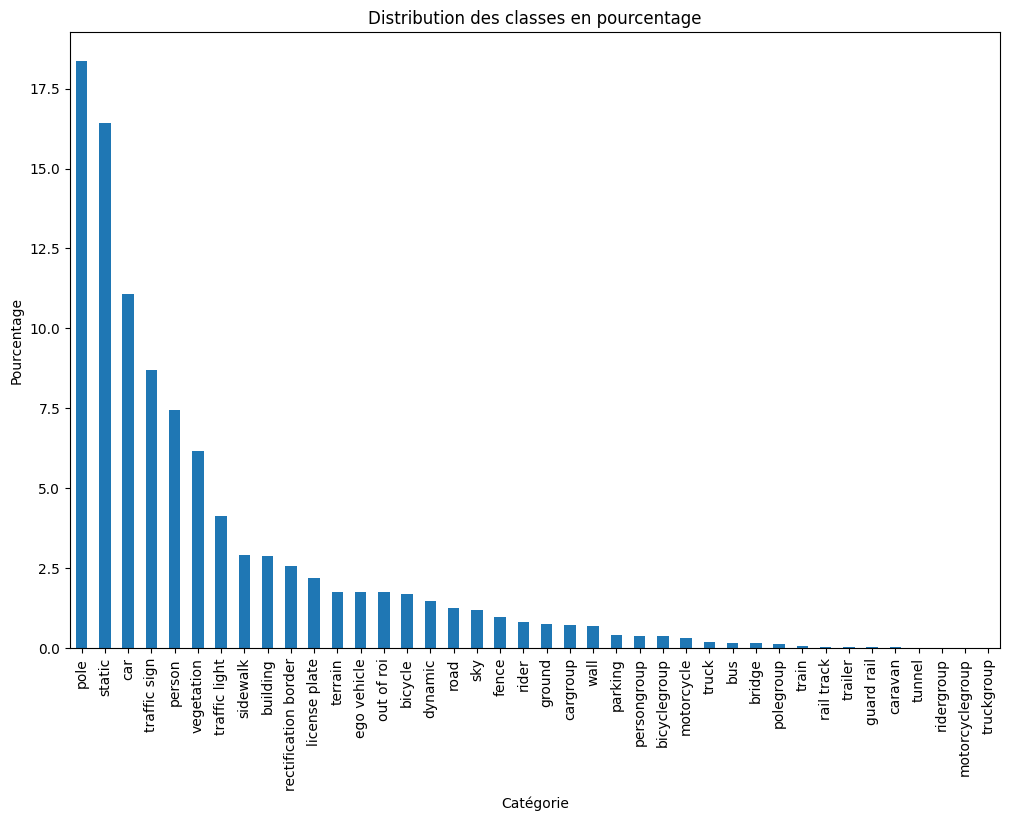

In [4]:
# Analyse de la distribution des classes
plt.figure(figsize=(12, 8))
category_counts.plot(kind='bar')
plt.title('Distribution des classes dans les fichiers JSON')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.show()

# Vérifier l'équilibre des classes
total_instances = category_counts.sum()
class_distribution = (category_counts / total_instances) * 100
print("Distribution des classes en pourcentage :")
print(class_distribution)

# Visualiser la distribution des classes en pourcentage
plt.figure(figsize=(12, 8))
class_distribution.plot(kind='bar')
plt.title('Distribution des classes en pourcentage')
plt.xlabel('Catégorie')
plt.ylabel('Pourcentage')
plt.show()

In [1]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# Définition des classes principales et de leur encodage
CLASSES = {
    "pole": 0, "static": 1, "car": 2, "traffic sign": 3,
    "person": 4, "vegetation": 5, "traffic light": 6, "sidewalk": 7
}

# Correspondance entre les classes secondaires et les classes principales
CLASS_MAPPING = {
    "pole": "pole", "pole group": "pole",
    "static": "static", "ground": "static",
    "car": "car", "truck": "car", "bus": "car", "on rails": "car", 
    "motorcycle": "car", "bicycle": "car", "caravan": "car", "trailer": "car",
    "traffic sign": "traffic sign",
    "person": "person", "rider": "person",
    "vegetation": "vegetation", "terrain": "vegetation",
    "traffic light": "traffic light",
    "sidewalk": "sidewalk", "road": "sidewalk", "parking": "sidewalk", "rail track": "sidewalk"
}

def create_segmentation_mask(json_path, img_width, img_height, debug=False):
    """ Génère un masque de segmentation à partir d'un fichier JSON """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    mask = np.full((img_height, img_width), 255, dtype=np.uint8)  # 255 = background/ignore
    
    if debug:
        print(f"Fichier JSON : {json_path}")
        print("Labels trouvés :", [obj['label'] for obj in data['objects']])
    
    found_classes_of_interest = False
    
    for obj in data['objects']:
        label = obj['label']
        primary_label = CLASS_MAPPING.get(label, None)
        if primary_label and primary_label in CLASSES:
            polygon = np.array(obj['polygon'], np.int32)
            cv2.fillPoly(mask, [polygon], CLASSES[primary_label])
            found_classes_of_interest = True
        elif debug:
            print(f"Label '{label}' not in CLASS_MAPPING, skipping.")
    
    return mask, found_classes_of_interest

def process_dataset(gtfine_dir, output_dir, debug=False):
    """ Parcourt le dossier GTFine et génère des masques """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    total_images = 0
    saved_images = 0
    
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(gtfine_dir, split)
        output_split_dir = os.path.join(output_dir, split)
        os.makedirs(output_split_dir, exist_ok=True)
        
        for city in tqdm(os.listdir(split_dir), desc=f'Processing {split}'):
            city_dir = os.path.join(split_dir, city)
            output_city_dir = os.path.join(output_split_dir, city)
            os.makedirs(output_city_dir, exist_ok=True)
            
            for file in os.listdir(city_dir):
                if file.endswith('_gtFine_polygons.json'):
                    total_images += 1
                    json_path = os.path.join(city_dir, file)
                    image_name = file.replace('_gtFine_polygons.json', '_gtFine_color.png')
                    
                    # Charger une image pour récupérer ses dimensions
                    img_path = os.path.join(city_dir, image_name)
                    if not os.path.exists(img_path):
                        print(f"Image not found: {img_path}")
                        continue
                    
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Failed to read image: {img_path}")
                        continue
                    
                    mask, has_classes_of_interest = create_segmentation_mask(json_path, img.shape[1], img.shape[0], debug)
                    
                    # Ne sauvegarder que si des classes d'intérêt sont présentes
                    if has_classes_of_interest:
                        # Sauvegarde du masque
                        mask_path = os.path.join(output_city_dir, file.replace('_gtFine_polygons.json', '_mask.png'))
                        cv2.imwrite(mask_path, mask)
                        saved_images += 1
                        if debug:
                            print(f"Mask saved: {mask_path}")
                    elif debug:
                        print(f"Skipping {file} - No classes of interest found")
    
    print(f"Processing complete: {saved_images}/{total_images} images contained classes of interest and were saved.")

# Exécution du script
gtfine_path = "./gtfine"
output_path = "./output_masks"
process_dataset(gtfine_path, output_path, debug=True)

Processing train:   0%|          | 0/18 [00:00<?, ?it/s]

Fichier JSON : ./gtfine\train\aachen\aachen_000000_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sidewalk', 'car', 'car', 'car', 'sky', 'terrain', 'building', 'building', 'car', 'terrain', 'terrain', 'sidewalk', 'car', 'vegetation', 'car', 'pole', 'pole', 'pole', 'pole', 'car', 'traffic sign', 'car', 'pole', 'static', 'pole', 'car', 'pole', 'vegetation', 'pole', 'pole', 'vegetation', 'pole', 'pole', 'traffic sign', 'pole', 'car', 'static', 'static', 'pole', 'traffic sign', 'traffic sign', 'traffic sign', 'static', 'vegetation', 'static', 'vegetation', 'bicycle', 'person', 'traffic sign', 'pole', 'pole', 'person', 'car', 'traffic sign', 'pole', 'pole', 'license plate', 'terrain', 'rider', 'license plate', 'pole', 'traffic sign', 'traffic sign', 'traffic sign', 'bicycle', 'pole', 'traffic sign', 'static', 'pole', 'license plate', 'static', 'static', 'static', 'static', 'static', 'static', 'static', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'b

Processing train:   6%|▌         | 1/18 [00:07<01:59,  7.01s/it]

Fichier JSON : ./gtfine\train\aachen\aachen_000170_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sky', 'static', 'building', 'car', 'car', 'sidewalk', 'sidewalk', 'sidewalk', 'terrain', 'terrain', 'terrain', 'car', 'car', 'vegetation', 'terrain', 'car', 'pole', 'terrain', 'terrain', 'static', 'car', 'pole', 'vegetation', 'vegetation', 'vegetation', 'traffic light', 'traffic light', 'static', 'pole', 'traffic light', 'traffic light', 'pole', 'traffic sign', 'static', 'traffic light', 'pole', 'traffic sign', 'traffic sign', 'static', 'pole', 'pole', 'pole', 'traffic light', 'traffic sign', 'pole', 'static', 'traffic light', 'traffic sign', 'pole', 'static', 'static', 'car', 'pole', 'car', 'car', 'traffic sign', 'pole', 'static', 'traffic light', 'traffic light', 'car', 'pole', 'pole', 'traffic light', 'static', 'car', 'car', 'traffic sign', 'car', 'car', 'car', 'license plate', 'car', 'license plate', 'car', 'car', 'car', 'car', 'car', 'dynamic', 'pole', 'traffic sign', 'pole', 

Processing train:  11%|█         | 2/18 [00:10<01:23,  5.20s/it]

Fichier JSON : ./gtfine\train\bochum\bochum_000000_037039_gtFine_polygons.json
Labels trouvés : ['sky', 'building', 'static', 'road', 'sidewalk', 'person', 'sidewalk', 'sidewalk', 'ground', 'sidewalk', 'terrain', 'wall', 'vegetation', 'vegetation', 'pole', 'vegetation', 'bridge', 'vegetation', 'vegetation', 'pole', 'static', 'pole', 'static', 'static', 'static', 'pole', 'static', 'pole', 'traffic light', 'static', 'traffic light', 'cargroup', 'car', 'motorcycle', 'pole', 'traffic light', 'static', 'static', 'car', 'car', 'car', 'car', 'car', 'cargroup', 'pole', 'traffic light', 'traffic sign', 'static', 'traffic light', 'static', 'person', 'car', 'pole', 'person', 'wall', 'person', 'fence', 'vegetation', 'traffic sign', 'traffic sign', 'static', 'pole', 'pole', 'static', 'static', 'static', 'static', 'pole', 'traffic light', 'traffic sign', 'traffic sign', 'static', 'static', 'static', 'terrain', 'static', 'static', 'pole', 'static', 'traffic light', 'static', 'pole', 'static', 'pole',

Processing train:  17%|█▋        | 3/18 [00:23<02:08,  8.54s/it]

Fichier JSON : ./gtfine\train\bremen\bremen_000315_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sky', 'sidewalk', 'sidewalk', 'building', 'vegetation', 'static', 'static', 'pole', 'fence', 'car', 'pole', 'traffic sign', 'traffic sign', 'car', 'car', 'car', 'car', 'car', 'car', 'static', 'static', 'traffic sign', 'static', 'traffic sign', 'pole', 'pole', 'traffic sign', 'traffic sign', 'bicycle', 'car', 'person', 'person', 'car', 'car', 'car', 'car', 'license plate', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Mask saved: ./output_masks\train\bremen\bremen_000315_000019_mask.png
Fichier JSON : ./gtfine\train\cologne\cologne_000000_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'vegetation', 'veg

Processing train:  22%|██▏       | 4/18 [00:29<01:46,  7.58s/it]

Fichier JSON : ./gtfine\train\darmstadt\darmstadt_000000_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'building', 'road', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'static', 'static', 'sidewalk', 'sidewalk', 'traffic sign', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'pole', 'traffic sign', 'license plate', 'license plate', 'license plate', 'license plate', 'license plate', 'license plate', 'static', 'static', 'static', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_M

Processing train:  28%|██▊       | 5/18 [00:33<01:19,  6.11s/it]

Fichier JSON : ./gtfine\train\darmstadt\darmstadt_000081_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'sidewalk', 'sidewalk', 'rail track', 'building', 'building', 'building', 'vegetation', 'sidewalk', 'sidewalk', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'car', 'car', 'ground', 'wall', 'terrain', 'building', 'bus', 'truck', 'car', 'car', 'vegetation', 'car', 'car', 'car', 'vegetation', 'car', 'car', 'car', 'bicycle', 'bicycle', 'person', 'person', 'person', 'person', 'pole', 'pole', 'pole', 'pole', 'traffic sign', 'pole', 'pole', 'building', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'person', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'person', 'car', 'pole', 'fence', 'pole', 'car', 'pole', 'pole', 'vegetation', 'rider', 'pole', 'pole', 'pole', 'pole', 'pole', 'traffic sign', 'static', 'static', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'traffic sign', 'building', 'tr

Processing train:  33%|███▎      | 6/18 [00:41<01:22,  6.92s/it]

Fichier JSON : ./gtfine\train\dusseldorf\dusseldorf_000218_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sidewalk', 'sky', 'sidewalk', 'building', 'sidewalk', 'terrain', 'pole', 'pole', 'traffic light', 'traffic sign', 'static', 'static', 'pole', 'static', 'pole', 'car', 'car', 'car', 'car', 'car', 'motorcycle', 'motorcycle', 'bicyclegroup', 'car', 'bicyclegroup', 'pole', 'pole', 'traffic light', 'traffic light', 'traffic sign', 'car', 'static', 'static', 'car', 'car', 'sidewalk', 'traffic light', 'traffic light', 'pole', 'traffic light', 'traffic sign', 'traffic light', 'traffic light', 'pole', 'pole', 'traffic sign', 'static', 'pole', 'traffic sign', 'pole', 'pole', 'traffic sign', 'traffic sign', 'static', 'vegetation', 'pole', 'static', 'car', 'pole', 'car', 'car', 'traffic sign', 'car', 'car', 'license plate', 'license plate', 'license plate', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'b

Processing train:  39%|███▉      | 7/18 [00:45<01:06,  6.05s/it]

Fichier JSON : ./gtfine\train\hamburg\hamburg_000000_000042_gtFine_polygons.json
Labels trouvés : ['road', 'sidewalk', 'terrain', 'terrain', 'sidewalk', 'terrain', 'sky', 'building', 'wall', 'building', 'building', 'static', 'vegetation', 'truck', 'car', 'vegetation', 'static', 'vegetation', 'static', 'pole', 'vegetation', 'pole', 'person', 'motorcycle', 'pole', 'pole', 'static', 'pole', 'vegetation', 'rider', 'bicycle', 'road', 'pole', 'traffic sign', 'vegetation', 'static', 'static', 'traffic sign', 'pole', 'traffic light', 'terrain', 'pole', 'traffic light', 'fence', 'pole', 'traffic light', 'car', 'static', 'static', 'bicycle', 'vegetation', 'terrain', 'static', 'traffic light', 'terrain', 'pole', 'traffic light', 'pole', 'traffic light', 'person', 'traffic sign', 'car', 'person', 'vegetation', 'wall', 'vegetation', 'car', 'license plate', 'static', 'vegetation', 'static', 'car', 'vegetation', 'vegetation', 'static', 'static', 'static', 'pole', 'pole', 'traffic sign', 'pole', 'traf

Processing train:  44%|████▍     | 8/18 [00:55<01:13,  7.33s/it]

Mask saved: ./output_masks\train\hamburg\hamburg_000000_106102_mask.png
Fichier JSON : ./gtfine\train\hanover\hanover_000000_000164_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'sidewalk', 'vegetation', 'sidewalk', 'sidewalk', 'terrain', 'ground', 'terrain', 'terrain', 'ground', 'terrain', 'vegetation', 'wall', 'building', 'vegetation', 'vegetation', 'building', 'static', 'polegroup', 'pole', 'static', 'pole', 'vegetation', 'static', 'building', 'vegetation', 'vegetation', 'vegetation', 'traffic sign', 'traffic sign', 'pole', 'static', 'pole', 'pole', 'static', 'vegetation', 'traffic sign', 'static', 'pole', 'traffic light', 'traffic light', 'vegetation', 'static', 'terrain', 'cargroup', 'truck', 'cargroup', 'car', 'traffic sign', 'pole', 'vegetation', 'car', 'static', 'static', 'static', 'pole', 'car', 'car', 'car', 'static', 'pole', 'traffic light', 'traffic sign', 'traffic light', 'static', 'pole', 'pole', 'pole', 'static', 'static', 'static', 'static', 'pole', 'traffic sig

Processing train:  50%|█████     | 9/18 [01:03<01:07,  7.49s/it]

Fichier JSON : ./gtfine\train\hanover\hanover_000000_057710_gtFine_polygons.json
Labels trouvés : ['sky', 'car', 'building', 'car', 'road', 'sidewalk', 'sidewalk', 'car', 'terrain', 'terrain', 'wall', 'static', 'vegetation', 'static', 'car', 'car', 'terrain', 'person', 'bicycle', 'rider', 'pole', 'traffic sign', 'traffic sign', 'bicycle', 'rider', 'pole', 'traffic sign', 'vegetation', 'pole', 'traffic light', 'bicycle', 'rider', 'static', 'pole', 'pole', 'car', 'car', 'pole', 'traffic sign', 'car', 'pole', 'traffic light', 'traffic light', 'traffic sign', 'static', 'pole', 'pole', 'pole', 'pole', 'traffic light', 'traffic sign', 'pole', 'static', 'car', 'car', 'car', 'license plate', 'car', 'car', 'pole', 'traffic sign', 'traffic sign', 'static', 'static', 'pole', 'static', 'pole', 'traffic light', 'pole', 'static', 'pole', 'traffic light', 'pole', 'traffic light', 'static', 'car', 'wall', 'static', 'static', 'terrain', 'pole', 'static', 'terrain', 'terrain', 'license plate', 'license 

Processing train:  56%|█████▌    | 10/18 [01:08<00:52,  6.61s/it]

Mask saved: ./output_masks\train\jena\jena_000118_000019_mask.png
Fichier JSON : ./gtfine\train\krefeld\krefeld_000000_000108_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'building', 'sidewalk', 'terrain', 'wall', 'car', 'cargroup', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'car', 'vegetation', 'vegetation', 'static', 'rider', 'bicycle', 'vegetation', 'car', 'sidewalk', 'vegetation', 'car', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'car', 'pole', 'car', 'car', 'car', 'car', 'license plate', 'license plate', 'ground', 'pole', 'ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'wall' not in CLASS_MAPPING, skipping.
Label 'cargroup' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'ego v

Processing train:  61%|██████    | 11/18 [01:12<00:40,  5.77s/it]

Fichier JSON : ./gtfine\train\krefeld\krefeld_000000_035124_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'sidewalk', 'building', 'static', 'building', 'dynamic', 'terrain', 'static', 'pole', 'bicycle', 'static', 'static', 'static', 'vegetation', 'pole', 'static', 'pole', 'pole', 'vegetation', 'static', 'traffic light', 'cargroup', 'static', 'pole', 'cargroup', 'pole', 'pole', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'license plate', 'traffic sign', 'pole', 'pole', 'traffic light', 'cargroup', 'truck', 'car', 'car', 'pole', 'traffic sign', 'car', 'car', 'car', 'car', 'pole', 'traffic sign', 'traffic sign', 'static', 'car', 'car', 'license plate', 'car', 'license plate', 'ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'dynamic' not in CLASS_MA

Processing train:  67%|██████▋   | 12/18 [01:15<00:30,  5.14s/it]

Fichier JSON : ./gtfine\train\monchengladbach\monchengladbach_000001_000876_gtFine_polygons.json
Labels trouvés : ['road', 'sidewalk', 'terrain', 'sky', 'building', 'traffic sign', 'sidewalk', 'building', 'vegetation', 'vegetation', 'vegetation', 'vegetation', 'traffic light', 'static', 'static', 'car', 'sidewalk', 'terrain', 'static', 'pole', 'traffic sign', 'static', 'pole', 'static', 'car', 'terrain', 'pole', 'traffic light', 'traffic sign', 'static', 'traffic light', 'traffic light', 'static', 'pole', 'pole', 'traffic sign', 'traffic light', 'pole', 'person', 'cargroup', 'pole', 'pole', 'traffic sign', 'static', 'car', 'car', 'car', 'pole', 'traffic sign', 'traffic light', 'traffic light', 'static', 'pole', 'pole', 'traffic sign', 'terrain', 'vegetation', 'person', 'static', 'pole', 'traffic sign', 'static', 'pole', 'traffic light', 'traffic light', 'car', 'car', 'static', 'pole', 'terrain', 'vegetation', 'car', 'traffic light', 'pole', 'traffic sign', 'pole', 'traffic light', 'tra

Processing train:  72%|███████▏  | 13/18 [01:30<00:39,  7.85s/it]

Mask saved: ./output_masks\train\strasbourg\strasbourg_000001_065214_mask.png
Fichier JSON : ./gtfine\train\strasbourg\strasbourg_000001_065572_gtFine_polygons.json
Labels trouvés : ['road', 'building', 'sidewalk', 'car', 'car', 'license plate', 'building', 'sidewalk', 'static', 'static', 'pole', 'pole', 'traffic light', 'traffic light', 'static', 'pole', 'static', 'static', 'pole', 'static', 'static', 'car', 'car', 'car', 'license plate', 'car', 'license plate', 'static', 'ground', 'ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'building' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectifi

Processing train:  78%|███████▊  | 14/18 [01:37<00:30,  7.72s/it]

Fichier JSON : ./gtfine\train\stuttgart\stuttgart_000194_000019_gtFine_polygons.json
Labels trouvés : ['vegetation', 'tunnel', 'road', 'ground', 'terrain', 'car', 'license plate', 'vegetation', 'traffic sign', 'traffic sign', 'vegetation', 'sidewalk', 'terrain', 'static', 'vegetation', 'pole', 'traffic sign', 'traffic sign', 'fence', 'pole', 'traffic sign', 'traffic sign', 'static', 'static', 'static', 'car', 'bus', 'license plate', 'car', 'license plate', 'ego vehicle', 'out of roi']
Label 'tunnel' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Mask saved: ./output_masks\train\stuttgart\stuttgart_000194_000019_mask.png
Fichier JSON : ./gtfine\train\stuttgart\stuttgart_000195_000019_gtFine_polyg

Processing train:  83%|████████▎ | 15/18 [01:43<00:21,  7.08s/it]

Fichier JSON : ./gtfine\train\tubingen\tubingen_000141_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'vegetation', 'road', 'building', 'sidewalk', 'sidewalk', 'vegetation', 'vegetation', 'building', 'vegetation', 'building', 'static', 'static', 'pole', 'static', 'static', 'pole', 'static', 'static', 'static', 'pole', 'car', 'car', 'car', 'car', 'car', 'car', 'traffic sign', 'traffic sign', 'vegetation', 'car', 'car', 'traffic sign', 'traffic sign', 'traffic sign', 'building', 'static', 'vegetation', 'pole', 'traffic sign', 'static', 'vegetation', 'wall', 'vegetation', 'car', 'car', 'car', 'static', 'car', 'car', 'license plate', 'license plate', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'wall' not in CLASS_MAPPING, skipping.
Label 'license plate' not

Processing train:  89%|████████▉ | 16/18 [01:46<00:12,  6.07s/it]

Fichier JSON : ./gtfine\train\ulm\ulm_000094_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'vegetation', 'car', 'sidewalk', 'vegetation', 'pole', 'static', 'sidewalk', 'terrain', 'pole', 'pole', 'traffic sign', 'pole', 'static', 'static', 'pole', 'static', 'pole', 'pole', 'traffic sign', 'pole', 'pole', 'pole', 'sidewalk', 'static', 'pole', 'building', 'static', 'static', 'terrain', 'pole', 'vegetation', 'static', 'bus', 'car', 'car', 'traffic sign', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Mask saved: ./output_masks\train\ulm\ulm_000094_000019_mask.png
Fichier JSON : ./gtfine\train\weimar\weimar_000000_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sky', 'sidewalk', 'building', 'vegetation', 'fence', 'vegetation', 'pole', 'pole', 'static', 'dynamic', 'pole', 'traffic sign', 'traffi

Processing train:  94%|█████████▍| 17/18 [01:52<00:05,  5.87s/it]

Fichier JSON : ./gtfine\train\weimar\weimar_000139_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'building', 'road', 'sidewalk', 'building', 'terrain', 'sidewalk', 'vegetation', 'static', 'fence', 'building', 'vegetation', 'static', 'static', 'car', 'car', 'traffic light', 'car', 'car', 'car', 'car', 'pole', 'traffic light', 'traffic sign', 'static', 'traffic sign', 'traffic sign', 'pole', 'static', 'polegroup', 'pole', 'traffic sign', 'person', 'person', 'car', 'car', 'car', 'car', 'terrain', 'terrain', 'static', 'person', 'pole', 'static', 'static', 'static', 'pole', 'vegetation', 'person', 'person', 'car', 'license plate', 'pole', 'static', 'pole', 'vegetation', 'vegetation', 'car', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'polegroup' not in CLASS_M

Processing train: 100%|██████████| 18/18 [01:56<00:00,  6.50s/it]


Fichier JSON : ./gtfine\train\zurich\zurich_000120_000019_gtFine_polygons.json
Labels trouvés : ['terrain', 'sky', 'road', 'sidewalk', 'sidewalk', 'vegetation', 'static', 'static', 'building', 'building', 'building', 'vegetation', 'car', 'pole', 'terrain', 'vegetation', 'car', 'car', 'pole', 'static', 'vegetation', 'building', 'building', 'person', 'pole', 'pole', 'traffic sign', 'traffic sign', 'car', 'car', 'car', 'ground', 'pole', 'static', 'traffic sign', 'ground', 'pole', 'traffic sign', 'traffic sign', 'building', 'vegetation', 'static', 'static', 'pole', 'static', 'building', 'pole', 'static', 'static', 'traffic sign', 'vegetation', 'vegetation', 'pole', 'traffic sign', 'traffic sign', 'pole', 'traffic sign', 'terrain', 'vegetation', 'pole', 'car', 'car', 'car', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.


Processing val:   0%|          | 0/3 [00:00<?, ?it/s]

Fichier JSON : ./gtfine\val\frankfurt\frankfurt_000000_000294_gtFine_polygons.json
Labels trouvés : ['sky', 'road', 'sidewalk', 'sidewalk', 'sidewalk', 'vegetation', 'pole', 'pole', 'building', 'building', 'vegetation', 'pole', 'traffic sign', 'fence', 'static', 'pole', 'static', 'person', 'car', 'building', 'pole', 'static', 'traffic sign', 'pole', 'pole', 'building', 'pole', 'traffic sign', 'traffic sign', 'pole', 'traffic sign', 'traffic sign', 'pole', 'person', 'car', 'pole', 'traffic sign', 'person', 'person', 'pole', 'traffic sign', 'traffic sign', 'car', 'building', 'static', 'static', 'static', 'pole', 'traffic sign', 'traffic sign', 'traffic sign', 'ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'building' not 

Processing val:  33%|███▎      | 1/3 [00:10<00:21, 10.65s/it]

Mask saved: ./output_masks\val\frankfurt\frankfurt_000001_083199_mask.png
Fichier JSON : ./gtfine\val\frankfurt\frankfurt_000001_083852_gtFine_polygons.json
Labels trouvés : ['road', 'sidewalk', 'parking', 'sidewalk', 'ground', 'sky', 'vegetation', 'building', 'pole', 'building', 'building', 'static', 'vegetation', 'parking', 'sidewalk', 'static', 'static', 'pole', 'sidewalk', 'pole', 'terrain', 'pole', 'pole', 'ground', 'parking', 'traffic sign', 'pole', 'pole', 'vegetation', 'ground', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'pole', 'vegetation', 'pole', 'static', 'car', 'parking', 'terrain', 'car', 'cargroup', 'car', 'car', 'car', 'traffic sign', 'car', 'traffic light', 'pole', 'traffic light', 'person', 'pole', 'person', 'terrain', 'static', 'car', 'license plate', 'pole', 'traffic sign', 'pole', 'car', 'license plate', 'terrain', 'car', 'license plate', 'vegetation', 'static', 'car', 'bridge', 'pole', 'traffic sign', 'traffic sign', 'car', 'terrain', 'static', 'pole

Processing val:  67%|██████▋   | 2/3 [00:13<00:05,  5.79s/it]

Fichier JSON : ./gtfine\val\lindau\lindau_000054_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'vegetation', 'road', 'sidewalk', 'fence', 'sidewalk', 'static', 'static', 'static', 'static', 'static', 'static', 'static', 'static', 'polegroup', 'pole', 'pole', 'static', 'pole', 'static', 'static', 'pole', 'static', 'static', 'pole', 'static', 'static', 'static', 'fence', 'sidewalk', 'pole', 'pole', 'car', 'person', 'license plate', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'polegroup' not in CLASS_MAPPING, skipping.
Label 'fence' not in CLASS_MAPPING, skipping.
Label 'license plate' not in CLASS_MAPPING, skipping.
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Mask saved: ./output_masks\val\lindau\lindau_000054_000019_mask.png
Fichier JSON : ./gtfine\val\lindau\lindau_000055_000019_gtFine_polygons.json
Labels trouvés : ['road', 'sky', 'vegetati

Processing val: 100%|██████████| 3/3 [00:20<00:00,  6.69s/it]


Fichier JSON : ./gtfine\val\munster\munster_000171_000019_gtFine_polygons.json
Labels trouvés : ['sky', 'vegetation', 'road', 'parking', 'building', 'pole', 'pole', 'static', 'cargroup', 'sidewalk', 'pole', 'vegetation', 'vegetation', 'fence', 'fence', 'static', 'vegetation', 'pole', 'static', 'pole', 'pole', 'pole', 'vegetation', 'pole', 'pole', 'static', 'static', 'static', 'pole', 'static', 'static', 'pole', 'static', 'pole', 'pole', 'sidewalk', 'terrain', 'vegetation', 'pole', 'static', 'static', 'static', 'static', 'person', 'pole', 'static', 'pole', 'terrain', 'static', 'static', 'pole', 'dynamic', 'static', 'person', 'static', 'static', 'pole', 'traffic sign', 'pole', 'traffic sign', 'truck', 'caravan', 'car', 'car', 'bus', 'rider', 'bicycle', 'rider', 'bicycle', 'static', 'static', 'pole', 'traffic sign', 'ego vehicle', 'out of roi']
Label 'sky' not in CLASS_MAPPING, skipping.
Label 'building' not in CLASS_MAPPING, skipping.
Label 'cargroup' not in CLASS_MAPPING, skipping.
Labe

Processing test:   0%|          | 0/6 [00:00<?, ?it/s]

Fichier JSON : ./gtfine\test\berlin\berlin_000000_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping berlin_000000_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\berlin\berlin_000001_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping berlin_000001_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\berlin\berlin_000002_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping berlin_000002_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\berlin\berlin_000003_000019_gtFine_polygo

Processing test:  17%|█▋        | 1/6 [00:14<01:11, 14.32s/it]

Fichier JSON : ./gtfine\test\berlin\berlin_000543_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping berlin_000543_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bielefeld\bielefeld_000000_000321_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping bielefeld_000000_000321_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bi

Processing test:  33%|███▎      | 2/6 [00:19<00:34,  8.68s/it]

Fichier JSON : ./gtfine\test\bielefeld\bielefeld_000000_065154_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping bielefeld_000000_065154_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bielefeld\bielefeld_000000_066195_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
L

Processing test:  50%|█████     | 3/6 [00:20<00:15,  5.27s/it]

Fichier JSON : ./gtfine\test\bonn\bonn_000037_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping bonn_000037_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bonn\bonn_000038_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping bonn_000038_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bonn\bonn_000039_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping bonn_000039_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\bonn\bonn_000040_000019_gtFine_polygons.json
Labels trouvés

Processing test:  67%|██████▋   | 4/6 [00:21<00:07,  3.81s/it]

Fichier JSON : ./gtfine\test\leverkusen\leverkusen_000057_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping leverkusen_000057_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\mainz\mainz_000000_000093_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping mainz_000000_000093_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\ma

Processing test:  83%|████████▎ | 5/6 [00:29<00:05,  5.21s/it]

Fichier JSON : ./gtfine\test\mainz\mainz_000003_015917_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping mainz_000003_015917_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\mainz\mainz_000003_016360_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'rectification border', 'rectification border', 'rectification border', 'rectification border', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'rectification border' not in CLASS_MAPPING, skipping.
Label 'rectification 

Processing test: 100%|██████████| 6/6 [00:39<00:00,  6.66s/it]

Fichier JSON : ./gtfine\test\munich\munich_000394_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping munich_000394_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\munich\munich_000395_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping munich_000395_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\munich\munich_000396_000019_gtFine_polygons.json
Labels trouvés : ['ego vehicle', 'out of roi']
Label 'ego vehicle' not in CLASS_MAPPING, skipping.
Label 'out of roi' not in CLASS_MAPPING, skipping.
Skipping munich_000396_000019_gtFine_polygons.json - No classes of interest found
Fichier JSON : ./gtfine\test\munich\munich_000397_000019_gtFine_polygo

Analysing output directory...


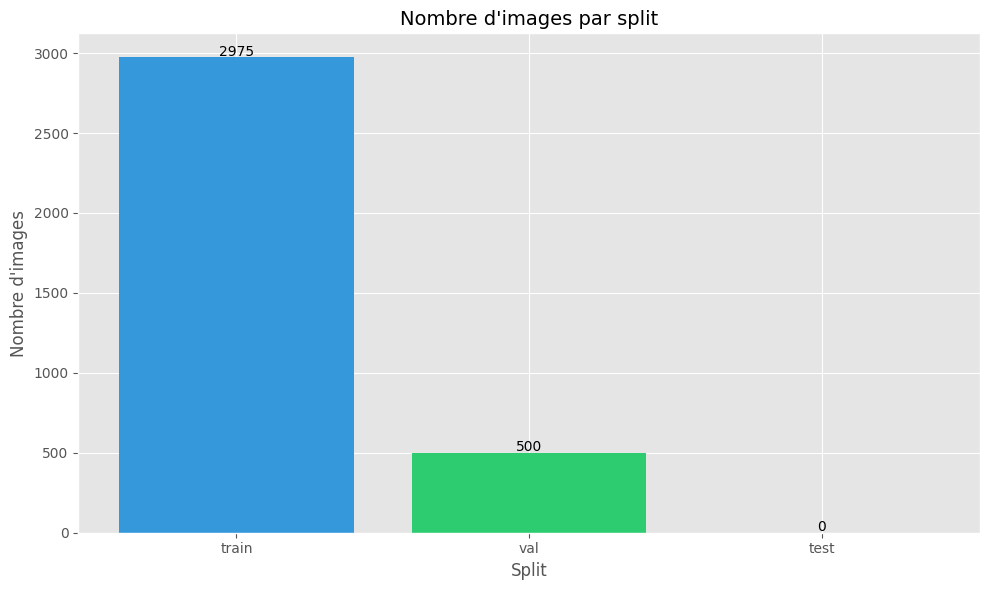

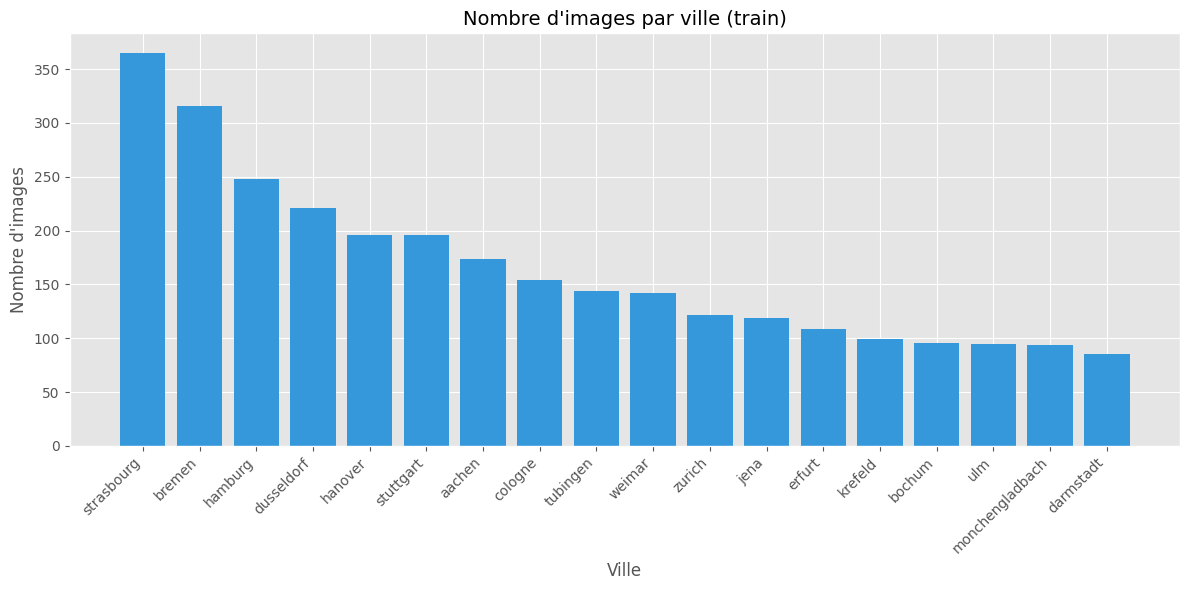

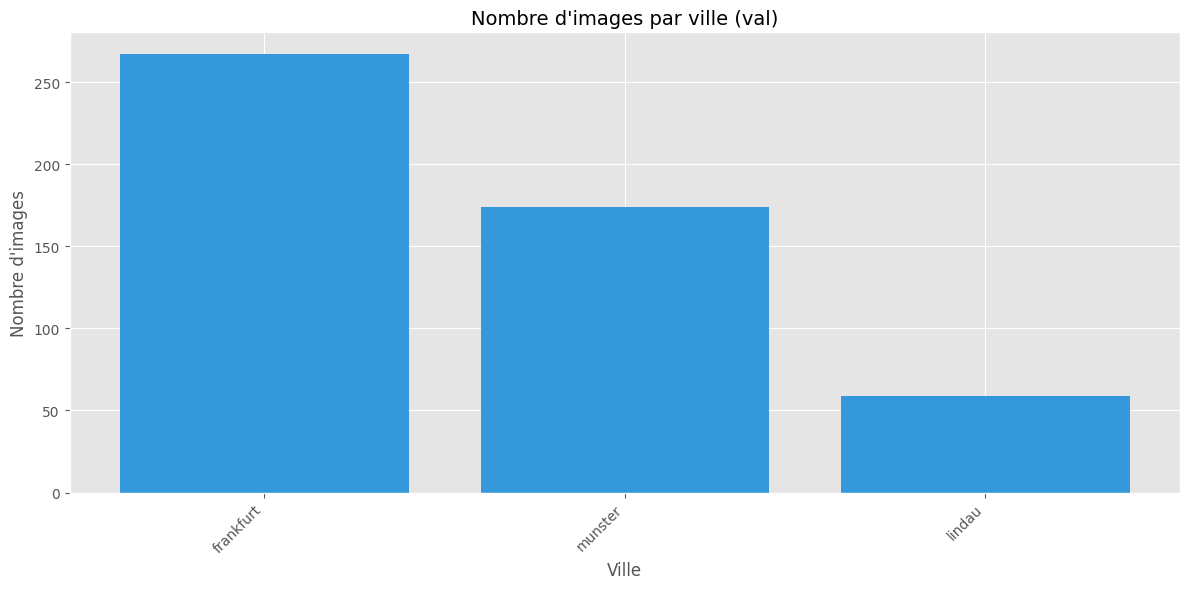

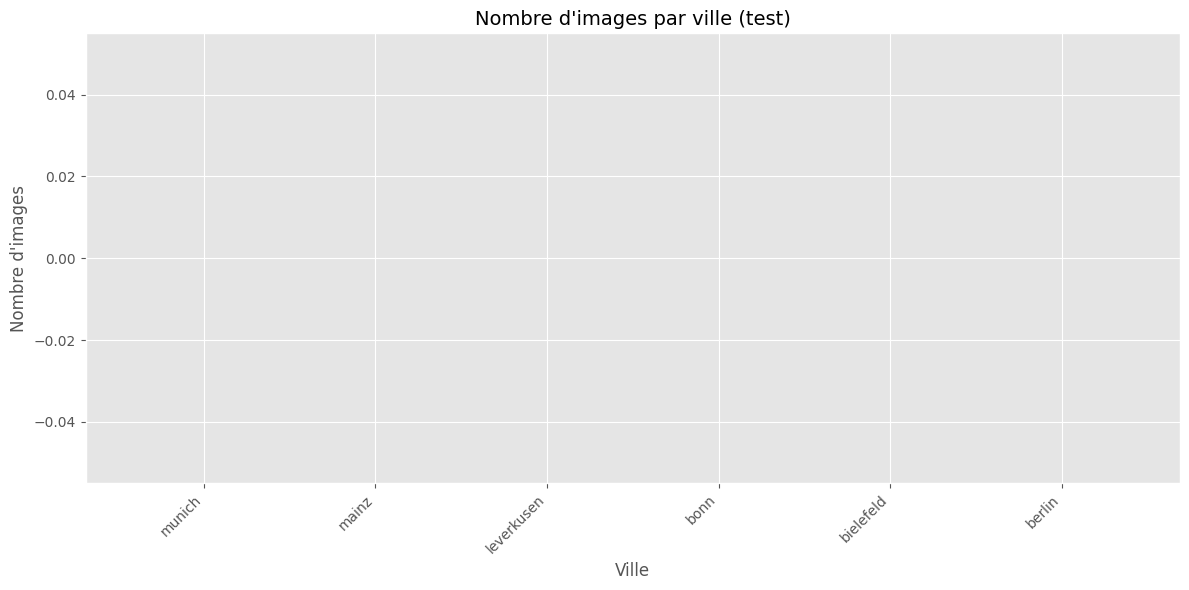

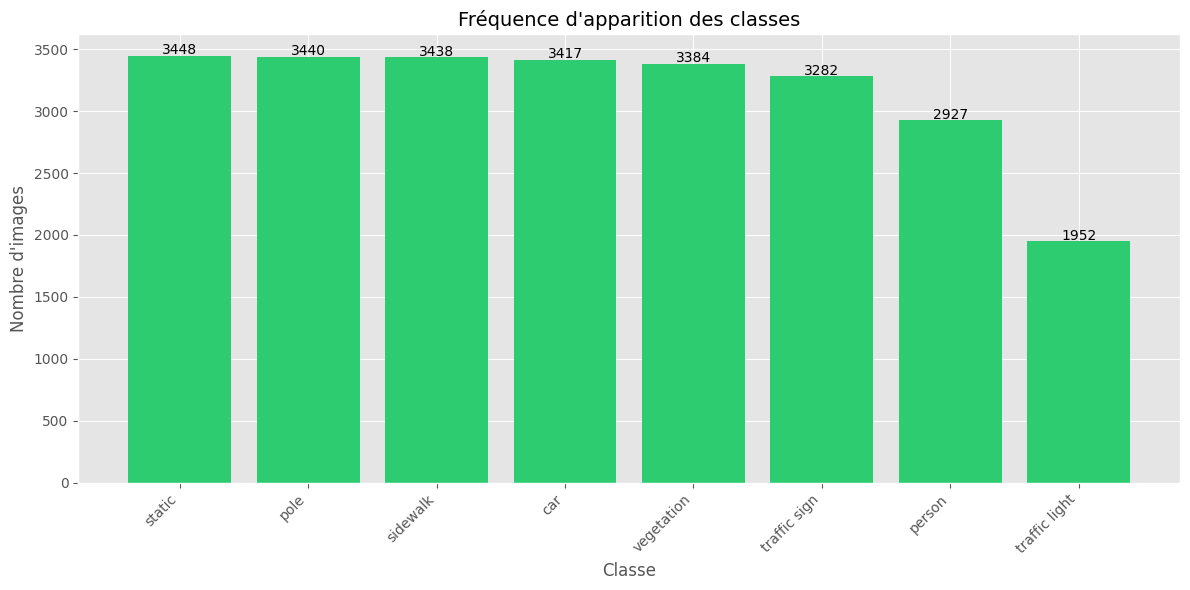

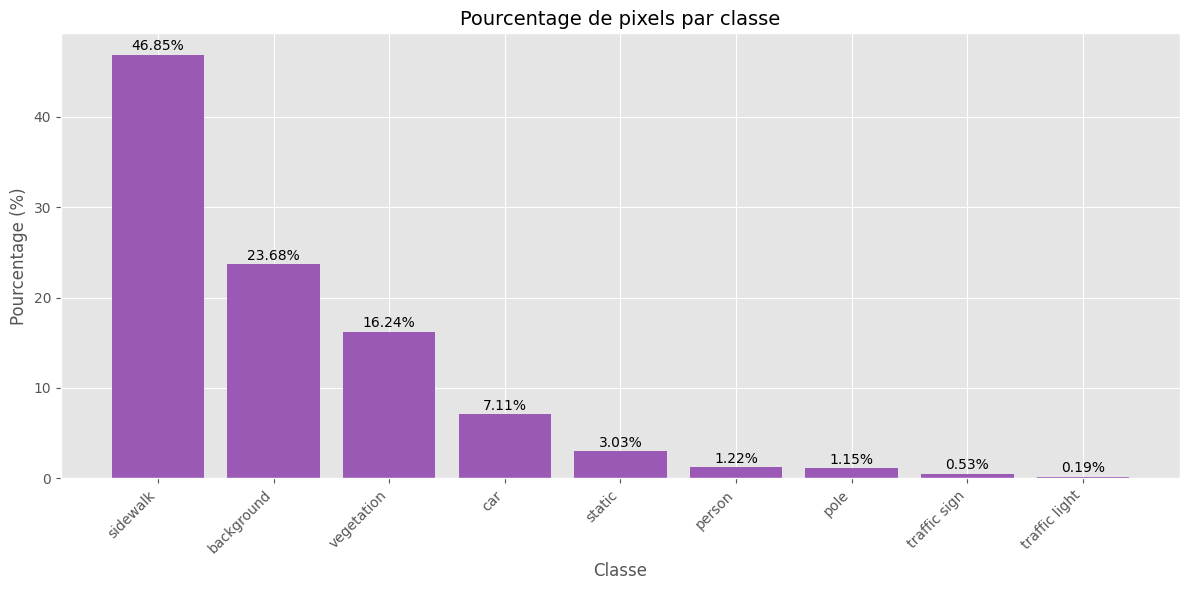

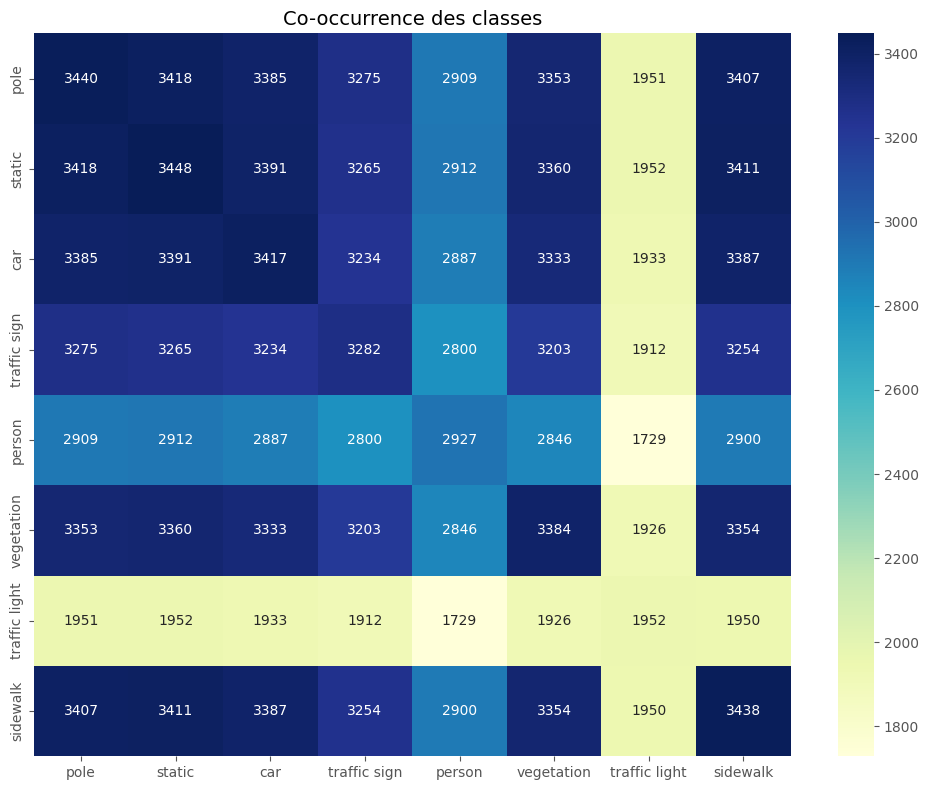

Nombre total d'images traitées: 3475
Nombre moyen de classes par image: 7.28

Classe la plus fréquente par ville:

TRAIN:
  aachen: analyse détaillée requise
  bochum: analyse détaillée requise
  bremen: analyse détaillée requise
  cologne: analyse détaillée requise
  darmstadt: analyse détaillée requise
  dusseldorf: analyse détaillée requise
  erfurt: analyse détaillée requise
  hamburg: analyse détaillée requise
  hanover: analyse détaillée requise
  jena: analyse détaillée requise
  krefeld: analyse détaillée requise
  monchengladbach: analyse détaillée requise
  strasbourg: analyse détaillée requise
  stuttgart: analyse détaillée requise
  tubingen: analyse détaillée requise
  ulm: analyse détaillée requise
  weimar: analyse détaillée requise
  zurich: analyse détaillée requise

VAL:
  frankfurt: analyse détaillée requise
  lindau: analyse détaillée requise
  munster: analyse détaillée requise

TEST:
  berlin: analyse détaillée requise
  bielefeld: analyse détaillée requise
  bonn

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from tqdm import tqdm
import pandas as pd

def analyze_output_masks(output_dir, classes_dict):
    """Analyse le contenu du dossier de sortie des masques"""
    
    # Statistiques globales
    split_stats = {}  # Pour compter les images par split
    city_stats = {}   # Pour compter les images par ville
    class_presence = defaultdict(int)  # Pour compter la présence des classes
    class_pixels = defaultdict(int)    # Pour compter les pixels par classe
    total_pixels = 0  # Pour calculer le pourcentage
    
    # Statistiques de co-occurrence
    cooccurrence = np.zeros((len(classes_dict) + 1, len(classes_dict) + 1))  # +1 pour le background (255)
    
    # Inverse du dictionnaire des classes pour la conversion des valeurs vers les noms
    inv_classes = {v: k for k, v in classes_dict.items()}
    inv_classes[255] = "background"
    
    print("Analysing output directory...")
    
    # Parcourir tous les fichiers
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            print(f"Split directory not found: {split_dir}")
            continue
        
        split_count = 0
        city_stats[split] = {}
        
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            if not os.path.isdir(city_dir):
                continue
                
            city_count = 0
            
            for file in os.listdir(city_dir):
                if file.endswith('_mask.png'):
                    # Compter les fichiers
                    split_count += 1
                    city_count += 1
                    
                    # Analyser le contenu du masque
                    mask_path = os.path.join(city_dir, file)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        print(f"Failed to read mask: {mask_path}")
                        continue
                    
                    # Compter les pixels par classe
                    unique_values, counts = np.unique(mask, return_counts=True)
                    total_pixels += mask.size
                    
                    # Mise à jour des compteurs de présence de classe et pixels
                    classes_in_image = set()
                    for val, count in zip(unique_values, counts):
                        # Ignorer le background pour le comptage des présences (optionnel)
                        if val != 255:
                            class_name = inv_classes.get(val, f"unknown ({val})")
                            class_presence[class_name] += 1
                            classes_in_image.add(val)
                        class_pixels[inv_classes.get(val, f"unknown ({val})")] += count
                    
                    # Mettre à jour la matrice de co-occurrence
                    classes_list = list(classes_in_image)
                    for i, class1 in enumerate(classes_list):
                        for class2 in classes_list[i:]:  # Inclut la diagonale (même classe)
                            cooccurrence[class1, class2] += 1
                            if class1 != class2:
                                cooccurrence[class2, class1] += 1
            
            city_stats[split][city] = city_count
        
        split_stats[split] = split_count
    
    # Calcul des pourcentages de pixels
    pixel_percentages = {k: (v / total_pixels) * 100 for k, v in class_pixels.items()}
    
    return {
        'split_stats': split_stats,
        'city_stats': city_stats,
        'class_presence': dict(class_presence),
        'pixel_percentages': pixel_percentages,
        'cooccurrence': cooccurrence,
        'inv_classes': inv_classes
    }

def visualize_statistics(stats):
    """Visualise les statistiques avec des graphiques"""
    # Configuration matplotlib
    plt.style.use('ggplot')
    
    # 1. Distribution par split
    plt.figure(figsize=(10, 6))
    splits = list(stats['split_stats'].keys())
    counts = list(stats['split_stats'].values())
    plt.bar(splits, counts, color=['#3498db', '#2ecc71', '#e74c3c'])
    plt.title('Nombre d\'images par split', fontsize=14)
    plt.xlabel('Split')
    plt.ylabel('Nombre d\'images')
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center')
    plt.tight_layout()
    plt.show()
    
    # 2. Distribution par ville (pour chaque split)
    for split, cities in stats['city_stats'].items():
        if not cities:
            continue
            
        plt.figure(figsize=(12, 6))
        city_names = list(cities.keys())
        city_counts = list(cities.values())
        
        # Trier par nombre d'images
        sorted_indices = np.argsort(city_counts)[::-1]
        city_names = [city_names[i] for i in sorted_indices]
        city_counts = [city_counts[i] for i in sorted_indices]
        
        plt.bar(city_names, city_counts, color='#3498db')
        plt.title(f'Nombre d\'images par ville ({split})', fontsize=14)
        plt.xlabel('Ville')
        plt.ylabel('Nombre d\'images')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # 3. Fréquence des classes
    plt.figure(figsize=(12, 6))
    classes = list(stats['class_presence'].keys())
    frequencies = list(stats['class_presence'].values())
    
    # Trier par fréquence
    sorted_indices = np.argsort(frequencies)[::-1]
    classes = [classes[i] for i in sorted_indices]
    frequencies = [frequencies[i] for i in sorted_indices]
    
    plt.bar(classes, frequencies, color='#2ecc71')
    plt.title('Fréquence d\'apparition des classes', fontsize=14)
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'images')
    plt.xticks(rotation=45, ha='right')
    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 10, str(freq), ha='center')
    plt.tight_layout()
    plt.show()
    
    # 4. Pourcentage de pixels par classe
    plt.figure(figsize=(12, 6))
    classes_px = list(stats['pixel_percentages'].keys())
    percentages = list(stats['pixel_percentages'].values())
    
    # Trier par pourcentage
    sorted_indices = np.argsort(percentages)[::-1]
    classes_px = [classes_px[i] for i in sorted_indices]
    percentages = [percentages[i] for i in sorted_indices]
    
    plt.bar(classes_px, percentages, color='#9b59b6')
    plt.title('Pourcentage de pixels par classe', fontsize=14)
    plt.xlabel('Classe')
    plt.ylabel('Pourcentage (%)')
    plt.xticks(rotation=45, ha='right')
    for i, pct in enumerate(percentages):
        plt.text(i, pct + 0.5, f"{pct:.2f}%", ha='center')
    plt.tight_layout()
    plt.show()
    
    # 5. Matrice de co-occurrence
    plt.figure(figsize=(10, 8))
    
    # Filtrer la matrice pour exclure le fond si nécessaire
    mask_classes = [v for k, v in CLASSES.items()]
    cooccur = stats['cooccurrence'][np.ix_(mask_classes, mask_classes)]
    
    # Créer des étiquettes lisibles
    labels = [stats['inv_classes'][i] for i in mask_classes]
    
    sns.heatmap(cooccur, annot=True, fmt='.0f', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels)
    plt.title('Co-occurrence des classes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Exécuter l'analyse
output_path = "./output_masks"  # Ajustez si nécessaire
stats = analyze_output_masks(output_path, CLASSES)
visualize_statistics(stats)

# Afficher quelques statistiques supplémentaires
total_images = sum(stats['split_stats'].values())
print(f"Nombre total d'images traitées: {total_images}")

avg_classes_per_image = sum(stats['class_presence'].values()) / total_images if total_images > 0 else 0
print(f"Nombre moyen de classes par image: {avg_classes_per_image:.2f}")

# Analyse de classe la plus fréquente par ville
print("\nClasse la plus fréquente par ville:")
for split, cities in stats['city_stats'].items():
    print(f"\n{split.upper()}:")
    for city in cities:
        # Cette partie nécessiterait une analyse plus détaillée des images par ville
        # que nous ne faisons pas dans ce script de base
        print(f"  {city}: analyse détaillée requise")

In [6]:
import os
import cv2
import numpy as np
import shutil
import random
from collections import defaultdict
from tqdm import tqdm

def redistribute_dataset(input_dir, output_dir, split_ratio=(0.7, 0.15, 0.15), seed=42):
    """
    Redistribue les images entre train/val/test tout en maintenant l'équilibre des classes
    
    Args:
        input_dir: Dossier contenant les masques générés (output_masks)
        output_dir: Dossier où seront stockées les images redistribuées
        split_ratio: Ratio train/val/test souhaité
        seed: Graine aléatoire pour reproductibilité
    """
    random.seed(seed)
    np.random.seed(seed)
    
    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    # Définir les noms des splits
    split_names = ['train', 'val', 'test']
    
    # Créer un dictionnaire pour stocker les informations sur chaque image
    image_info = defaultdict(list)
    
    print("Analyse des images existantes...")
    
    # Parcourir tous les fichiers pour collecter les informations
    for split in ['train', 'val']:
        split_dir = os.path.join(input_dir, split)
        if not os.path.exists(split_dir):
            continue
        
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            if not os.path.isdir(city_dir):
                continue
            
            for file in os.listdir(city_dir):
                if file.endswith('_mask.png'):
                    mask_path = os.path.join(city_dir, file)
                    
                    # Lire le masque pour déterminer les classes présentes
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        continue
                    
                    # Déterminer les classes présentes (sauf 255 qui est le fond)
                    unique_classes = np.unique(mask)
                    classes_present = [c for c in unique_classes if c != 255]
                    
                    # Stocker les informations
                    image_info[tuple(sorted(classes_present))].append({
                        'file': file,
                        'city': city,
                        'split': split,
                        'path': mask_path
                    })
    
    # Créer les dossiers pour chaque split dans la sortie
    for split in split_names:
        os.makedirs(os.path.join(output_dir, split), exist_ok=True)
    
    print("Redistribution des images...")
    
    # Pour chaque combinaison de classes, redistribuer les images
    total_images = {split: 0 for split in split_names}
    
    for classes, images in image_info.items():
        # Mélanger les images pour une répartition aléatoire
        random.shuffle(images)
        
        # Calculer combien d'images doivent aller dans chaque split
        n_images = len(images)
        n_train = int(n_images * split_ratio[0])
        n_val = int(n_images * split_ratio[1])
        
        # Assigner les images à chaque split
        split_assignments = ['train'] * n_train + ['val'] * n_val + ['test'] * (n_images - n_train - n_val)
        
        # S'assurer qu'il y a assez d'assignations
        while len(split_assignments) < n_images:
            split_assignments.append('test')
        
        # Pour chaque image, la déplacer vers son nouveau split
        for img, new_split in zip(images, split_assignments):
            # Mettre à jour le compteur
            total_images[new_split] += 1
            
            # Créer le dossier de la ville s'il n'existe pas
            city_dir = os.path.join(output_dir, new_split, img['city'])
            os.makedirs(city_dir, exist_ok=True)
            
            # Copier le masque
            dest_path = os.path.join(city_dir, img['file'])
            shutil.copy2(img['path'], dest_path)
            
            # Copier également l'image originale si disponible
            left_img_path = img['path'].replace('_mask.png', '_leftImg8bit.png')
            if os.path.exists(left_img_path):
                left_img_dest = dest_path.replace('_mask.png', '_leftImg8bit.png')
                shutil.copy2(left_img_path, left_img_dest)
    
    # Afficher le résultat
    print("Redistribution terminée!")
    for split in split_names:
        print(f"{split}: {total_images[split]} images")

# Appeler la fonction
input_dir = "./output_masks"
output_dir = "./balanced_dataset"
redistribute_dataset(input_dir, output_dir, split_ratio=(0.7, 0.15, 0.15))

Analyse des images existantes...
Redistribution des images...
Redistribution terminée!
train: 2405 images
val: 503 images
test: 567 images


Analysing output directory...


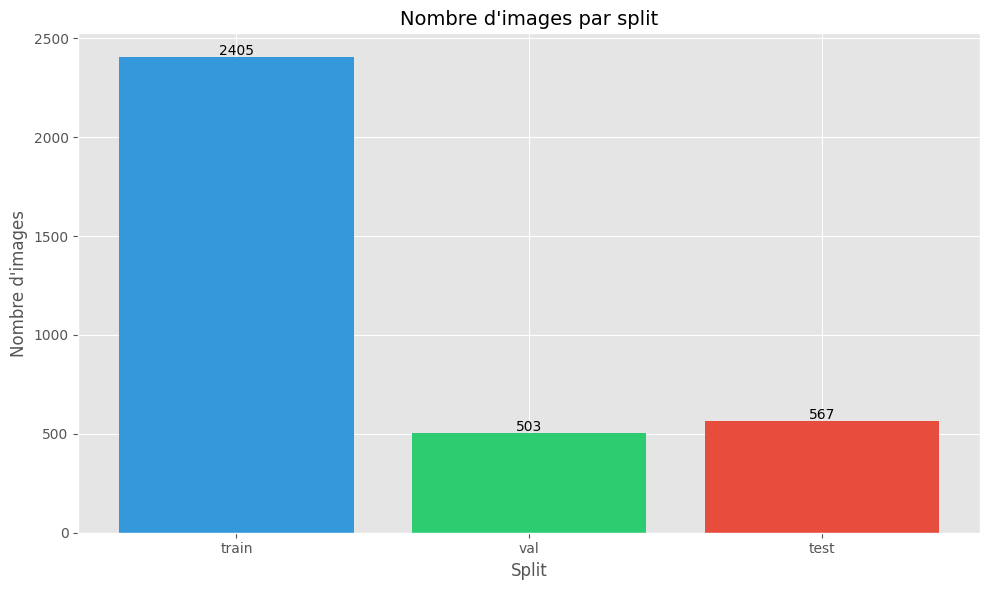

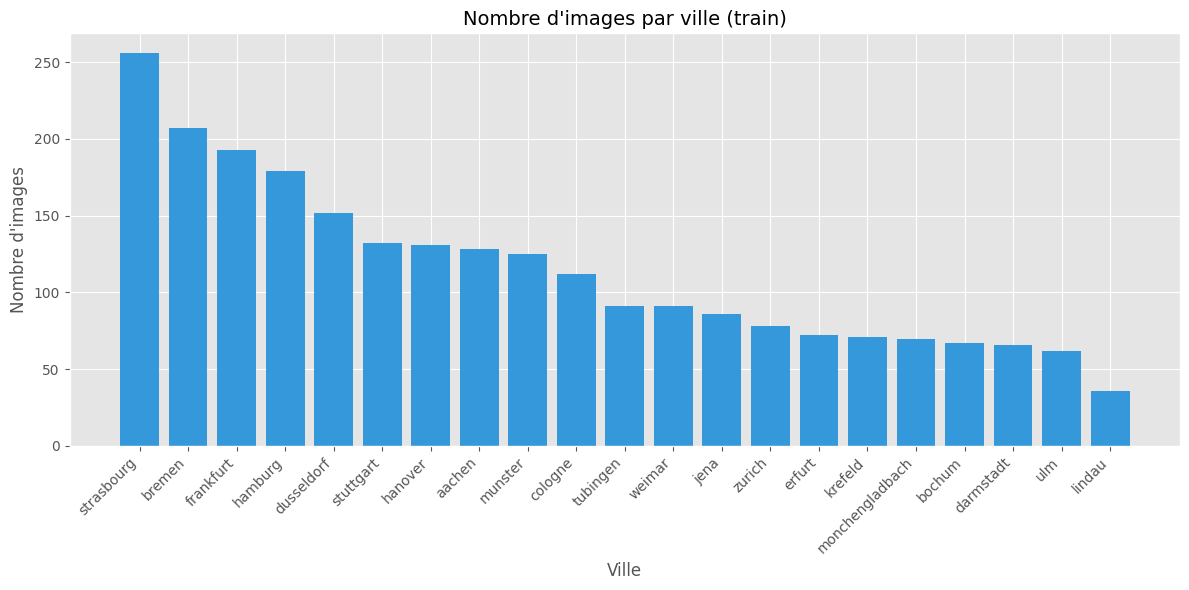

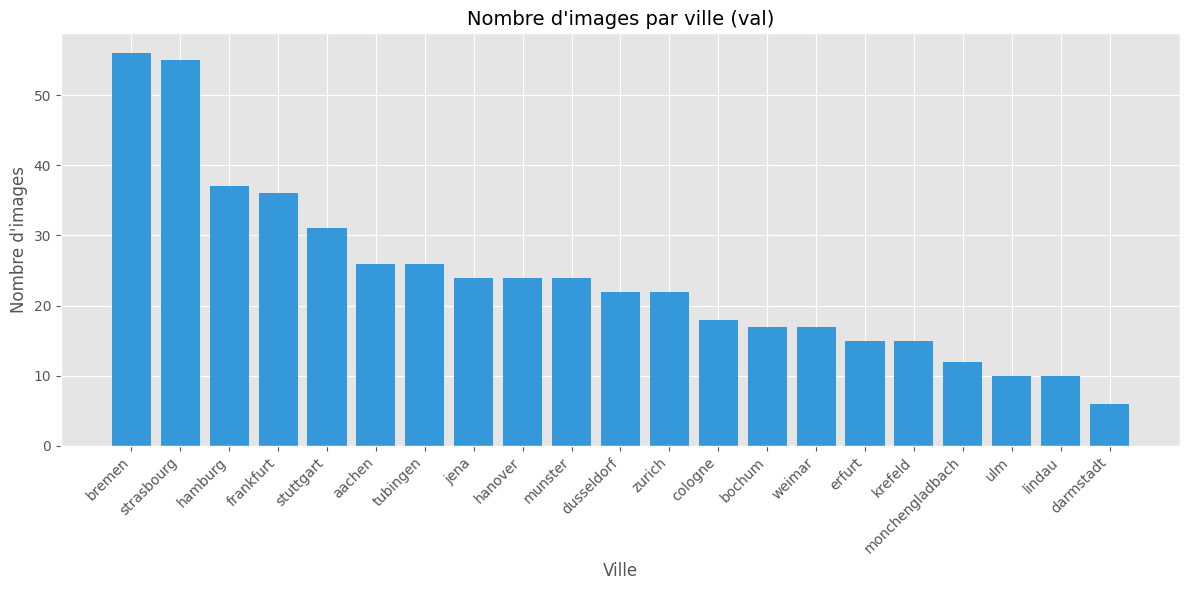

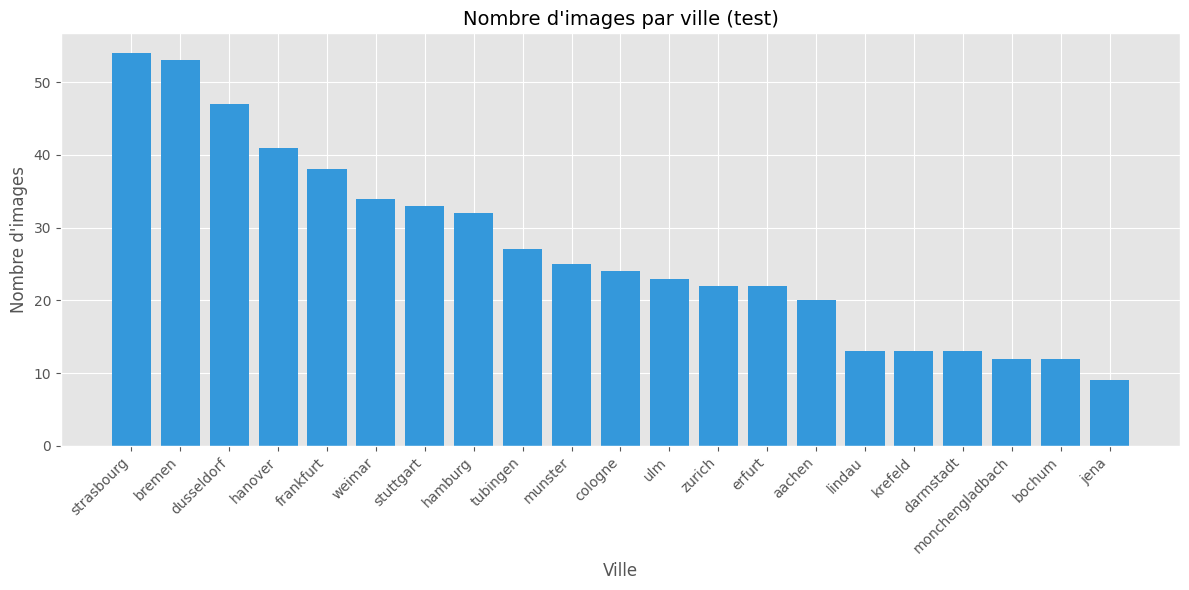

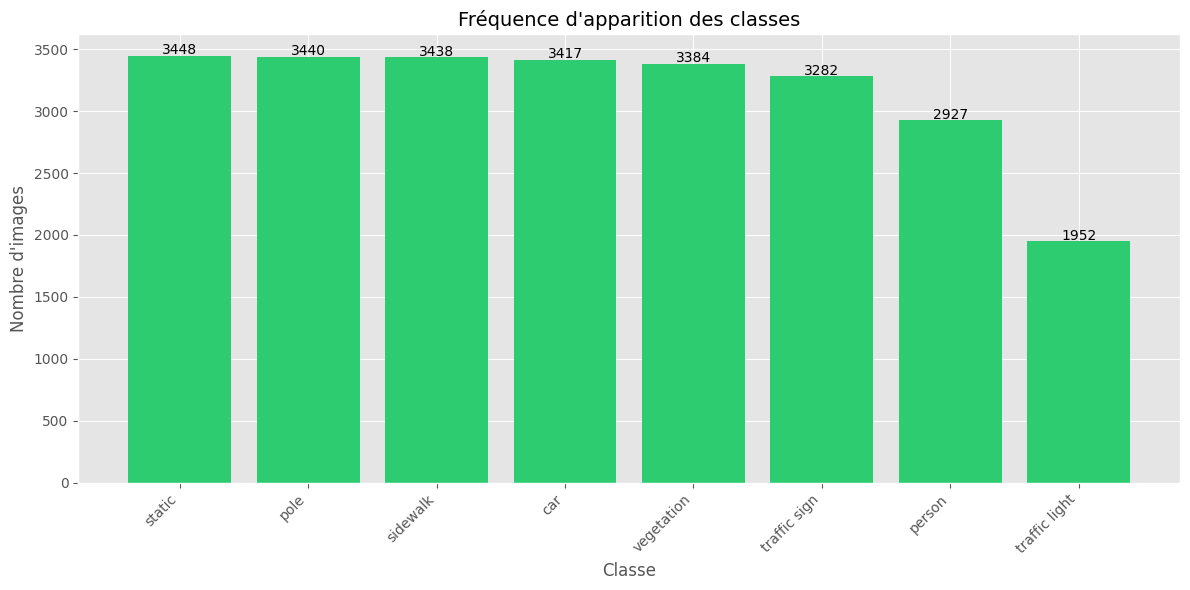

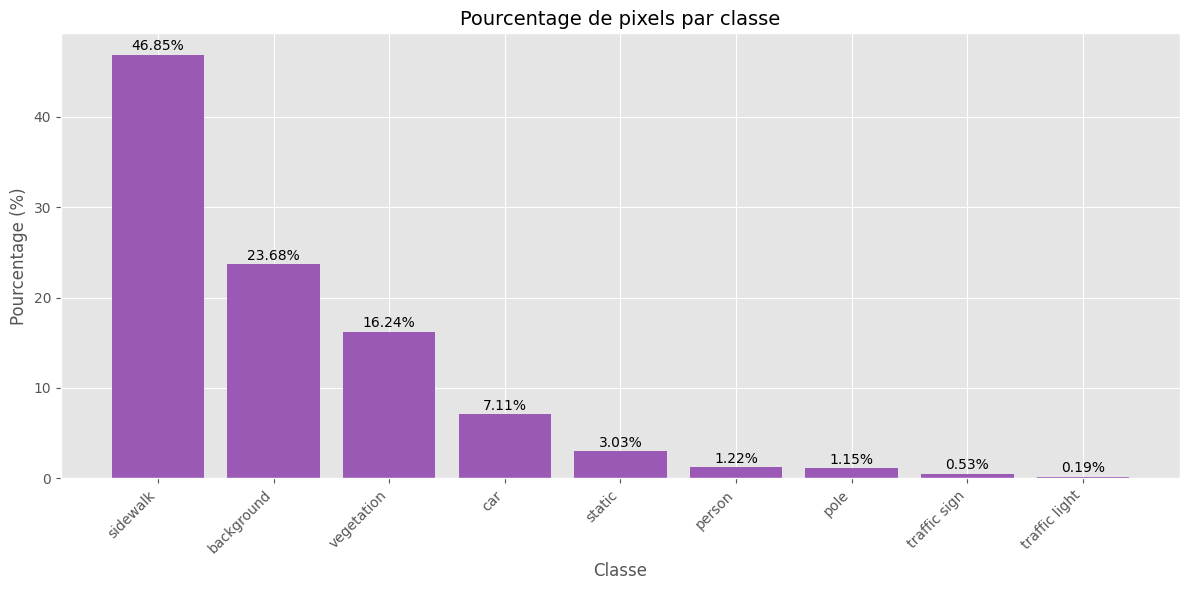

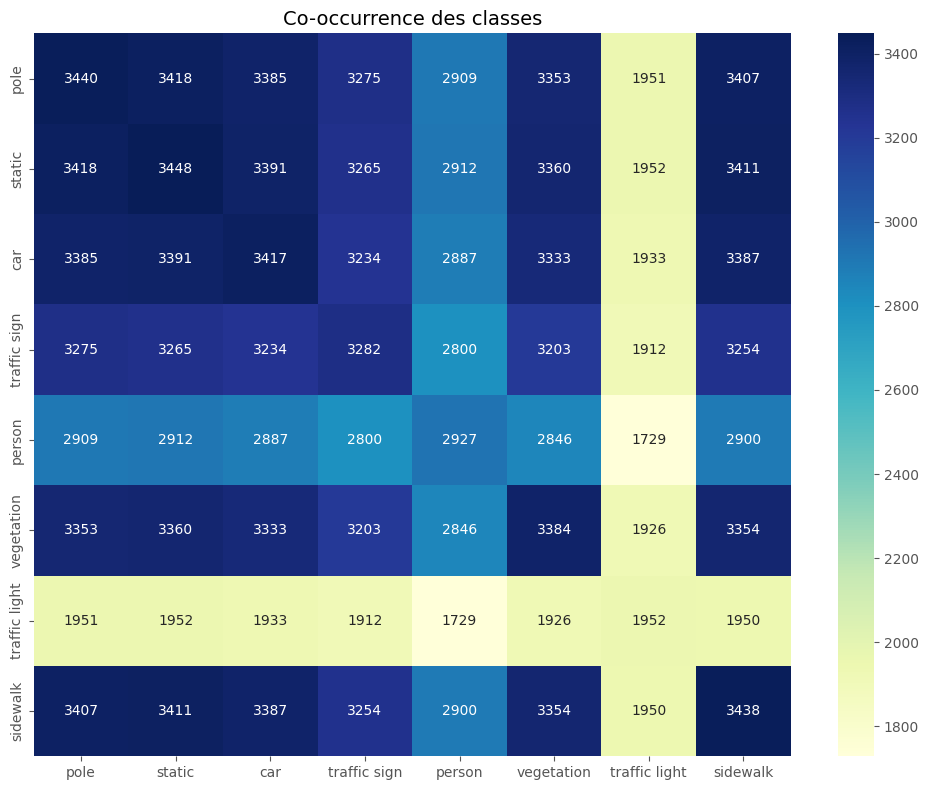

In [7]:
# Vérifier l'équilibre des classes dans la nouvelle distribution
output_path = "./balanced_dataset" 
balanced_stats = analyze_output_masks(output_path, CLASSES)
visualize_statistics(balanced_stats)

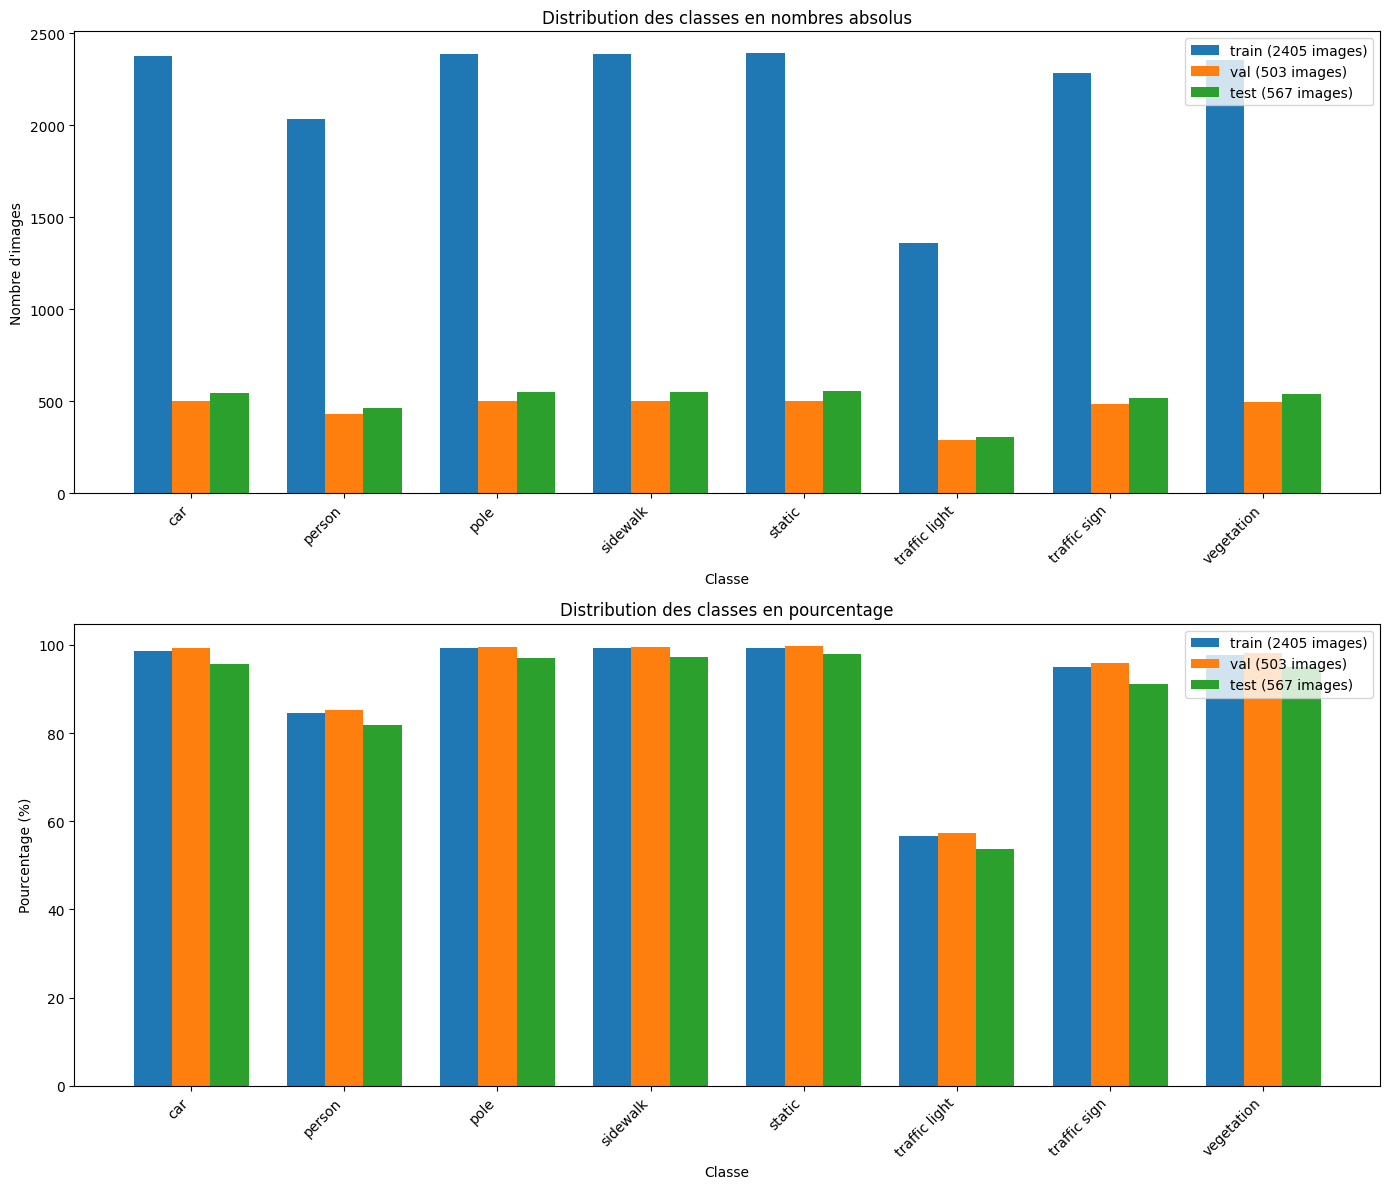

Divergence de distribution entre les ensembles:
  train vs val: 0.56% de différence moyenne
  train vs test: 2.65% de différence moyenne
  val vs test: 3.21% de différence moyenne

Analyse statistique des différences de distribution:
- car: Train 98.7%, Val 99.4%, Test 95.8%
- person: Train 84.6%, Val 85.3%, Test 81.8%
- pole: Train 99.3%, Val 99.6%, Test 97.0%
- sidewalk: Train 99.2%, Val 99.6%, Test 97.2%
- static: Train 99.4%, Val 99.8%, Test 97.9%
- traffic light: Train 56.5%, Val 57.3%, Test 53.6%
- traffic sign: Train 94.9%, Val 95.8%, Test 91.2%
- vegetation: Train 97.8%, Val 98.2%, Test 94.9%


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Définition des classes principales et de leur encodage
CLASSES = {
    "pole": 0, "static": 1, "car": 2, "traffic sign": 3,
    "person": 4, "vegetation": 5, "traffic light": 6, "sidewalk": 7
}

def analyze_class_balance(output_dir, classes_dict):
    """Analyse l'équilibre des classes entre train/val/test"""
    # Structure pour stocker les résultats
    class_counts = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
def analyze_class_balance(output_dir, classes_dict):
    """Analyse l'équilibre des classes entre train/val/test"""
    # Structure pour stocker les résultats
    class_counts = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
    # Structure pour les pourcentages
    class_percentages = {
        'train': {},
        'val': {},
        'test': {}
    }
    
    # Compteur d'images par split
    image_counts = {'train': 0, 'val': 0, 'test': 0}
    
    # Classes inversées pour lecture
    inv_classes = {v: k for k, v in classes_dict.items()}
    inv_classes[255] = "background"
    
    # Parcourir tous les fichiers
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(output_dir, split)
        if not os.path.exists(split_dir):
            continue
            
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            if not os.path.isdir(city_dir):
                continue
                
            for file in os.listdir(city_dir):
                if file.endswith('_mask.png'):
                    image_counts[split] += 1
                    
                    # Analyser le masque
                    mask_path = os.path.join(city_dir, file)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    if mask is None:
                        continue
                    
                    # Compter les classes présentes
                    unique_classes = np.unique(mask)
                    for class_val in unique_classes:
                        if class_val != 255:  # Ignorer le background
                            class_name = inv_classes.get(class_val, f"unknown ({class_val})")
                            class_counts[split][class_name] += 1
    
    # Calculer les pourcentages
    for split in ['train', 'val', 'test']:
        total = image_counts[split]
        if total == 0:
            continue
        for class_name, count in class_counts[split].items():
            class_percentages[split][class_name] = (count / total) * 100
            
    return class_counts, class_percentages, image_counts

def plot_class_balance(class_counts, class_percentages, image_counts):
    """Visualiser l'équilibre des classes"""
    # Obtenir toutes les classes uniques
    all_classes = set()
    for split in ['train', 'val', 'test']:
        all_classes.update(class_counts[split].keys())
    all_classes = sorted(list(all_classes))
    
    # Préparation des données pour le graphique
    splits = ['train', 'val', 'test']
    x = np.arange(len(all_classes))
    width = 0.25
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    
    # 1. Graphique des nombres absolus
    for i, split in enumerate(splits):
        counts = [class_counts[split].get(cls, 0) for cls in all_classes]
        ax1.bar(x + (i-1)*width, counts, width, label=f'{split} ({image_counts[split]} images)')
        
    ax1.set_xlabel('Classe')
    ax1.set_ylabel('Nombre d\'images')
    ax1.set_title('Distribution des classes en nombres absolus')
    ax1.set_xticks(x)
    ax1.set_xticklabels(all_classes, rotation=45, ha='right')
    ax1.legend()
    
    # 2. Graphique des pourcentages
    for i, split in enumerate(splits):
        percentages = [class_percentages[split].get(cls, 0) for cls in all_classes]
        ax2.bar(x + (i-1)*width, percentages, width, label=f'{split} ({image_counts[split]} images)')
        
    ax2.set_xlabel('Classe')
    ax2.set_ylabel('Pourcentage (%)')
    ax2.set_title('Distribution des classes en pourcentage')
    ax2.set_xticks(x)
    ax2.set_xticklabels(all_classes, rotation=45, ha='right')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculer la divergence entre les distributions
    print("Divergence de distribution entre les ensembles:")
    for i, split1 in enumerate(splits):
        for split2 in splits[i+1:]:
            diff_sum = 0
            for cls in all_classes:
                pct1 = class_percentages[split1].get(cls, 0)
                pct2 = class_percentages[split2].get(cls, 0)
                diff_sum += abs(pct1 - pct2)
            avg_diff = diff_sum / len(all_classes)
            print(f"  {split1} vs {split2}: {avg_diff:.2f}% de différence moyenne")

# Exécuter l'analyse
output_path = "./balanced_dataset"
class_counts, class_percentages, image_counts = analyze_class_balance(output_path, CLASSES)
plot_class_balance(class_counts, class_percentages, image_counts)

# Analyse statistique des différences
print("\nAnalyse statistique des différences de distribution:")
for class_name in sorted(CLASSES.keys()):
    train_pct = class_percentages['train'].get(class_name, 0)
    val_pct = class_percentages['val'].get(class_name, 0)
    test_pct = class_percentages['test'].get(class_name, 0)
    print(f"- {class_name}: Train {train_pct:.1f}%, Val {val_pct:.1f}%, Test {test_pct:.1f}%")

Imports et constantes

In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Définition des classes
CLASSES = {
    "pole": 0, "static": 1, "car": 2, "traffic sign": 3,
    "person": 4, "vegetation": 5, "traffic light": 6, "sidewalk": 7
}

Générateur de données

In [11]:
class CitySegmentationGenerator(Sequence):
    def __init__(self, root_dir, split='train', batch_size=8, img_size=(128, 256), augment=False):
        self.root_dir = root_dir
        self.split = split
        self.batch_size = batch_size
        self.img_size = img_size  # (height, width)
        self.augment = augment
        self.masks = []
        
        # Parcourir le répertoire pour trouver les masques
        split_dir = os.path.join(root_dir, split)
        if not os.path.exists(split_dir):
            print(f"Split directory not found: {split_dir}")
            return
            
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            if not os.path.isdir(city_dir):
                continue
                
            for file in os.listdir(city_dir):
                if file.endswith('_mask.png'):
                    mask_path = os.path.join(city_dir, file)
                    self.masks.append(mask_path)
        
        print(f"Total masks found for {split}: {len(self.masks)}")
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.masks) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_masks = self.masks[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_masks_processed = []
        
        for mask_path in batch_masks:
            # Chargement du masque
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Redimensionnement du masque
            mask = cv2.resize(mask, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_NEAREST)
            
            # Remplacer 255 par 8 (utilisé pour le background/fond)
            mask[mask == 255] = 8
            
            # Créer une image synthétique à partir du masque
            image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
            
            # Créer des couleurs distinctes pour chaque classe
            colors = {
                0: [128, 64, 128],   # pole - violet
                1: [70, 70, 70],     # static - gris
                2: [0, 0, 142],      # car - bleu foncé
                3: [220, 220, 0],    # traffic sign - jaune
                4: [220, 20, 60],    # person - rouge
                5: [107, 142, 35],   # vegetation - vert
                6: [250, 170, 30],   # traffic light - orange
                7: [244, 35, 232],   # sidewalk - rose
                8: [0, 0, 0]         # background - noir
            }
            
            # Attribuer des couleurs à chaque région
            for class_id, color in colors.items():
                image[mask == class_id] = color
            
            # Augmentation de données (si activée)
            if self.augment:
                if np.random.rand() > 0.5:
                    image = cv2.flip(image, 1)
                    mask = cv2.flip(mask, 1)
                
                if np.random.rand() > 0.5:
                    brightness = 0.8 + np.random.rand() * 0.4
                    image = np.clip(image * brightness, 0, 255).astype(np.uint8)
            
            # Normalisation de l'image
            image = image / 255.0
            
            # One-hot encoding
            mask_one_hot = tf.keras.utils.to_categorical(mask, num_classes=9)
            
            batch_images.append(image)
            batch_masks_processed.append(mask_one_hot)
        
        return np.array(batch_images), np.array(batch_masks_processed)
    
    def on_epoch_end(self):
        """Shuffle après chaque epoch"""
        np.random.shuffle(self.masks)

Fonctions de visualisation

In [12]:
def visualize_examples_keras(generator, num_samples=3):
    """Affiche des exemples du dataset"""
    if len(generator) == 0:
        print("Générateur vide, impossible d'afficher des exemples")
        return
        
    images, masks = generator.__getitem__(0)
    
    for i in range(min(num_samples, len(images))):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title('Image synthétisée')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        mask = np.argmax(masks[i], axis=-1)
        plt.imshow(mask, cmap='nipy_spectral', vmin=0, vmax=8)
        plt.title('Masque de segmentation')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

def plot_training_history(history):
    """Affiche les courbes d'apprentissage"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Callback pour limiter le temps d'entraînement

In [13]:
class TimeoutCallback(keras.callbacks.Callback):
    """Callback pour arrêter l'entraînement après un certain temps"""
    def __init__(self, max_seconds=1800):  # 30 minutes par défaut
        super().__init__()
        self.max_seconds = max_seconds
        self.start_time = None
    
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed > self.max_seconds:
            print(f"\nEntraînement arrêté après {elapsed/60:.1f} minutes (limite de {self.max_seconds/60:.1f} minutes atteinte)")
            self.model.stop_training = True

Modèle léger

In [14]:
def create_lightweight_unet(img_height, img_width, num_classes=9):
    """Version très légère d'UNet pour un entraînement rapide"""
    
    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bridge
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    
    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    merge4 = layers.Concatenate()([conv2, up4])
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge4)
    
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    merge5 = layers.Concatenate()([conv1, up5])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge5)
    
    # Output
    outputs = layers.Conv2D(num_classes, 1, padding='same')(conv5)  # Sans activation softmax
    
    model = keras.Model(inputs, outputs)
    return model

Fonction d'entraînement

In [15]:
def train_model_keras(img_height=512, img_width=1024, batch_size=4, epochs=10):
    """Version optimisée pour un entraînement léger et rapide"""
    
    # Configuration
    data_dir = "./balanced_dataset"
    num_classes = 9
    
    # Réduire les dimensions
    reduced_height = img_height // 4  # 512 -> 128
    reduced_width = img_width // 4    # 1024 -> 256
    img_size = (reduced_height, reduced_width)
    
    # Générateurs de données avec dimensions réduites
    train_gen = CitySegmentationGenerator(data_dir, 'train', batch_size, img_size, augment=True)
    val_gen = CitySegmentationGenerator(data_dir, 'val', batch_size, img_size, augment=False)
    test_gen = CitySegmentationGenerator(data_dir, 'test', batch_size, img_size, augment=False)
    
    print(f"Dimensions d'image réduites: {reduced_height}x{reduced_width}")
    print(f"Données chargées: {len(train_gen) * batch_size} échantillons d'entraînement, "
          f"{len(val_gen) * batch_size} de validation, {len(test_gen) * batch_size} de test")
    
    # Visualiser un exemple
    print("Visualisation d'un exemple d'entraînement:")
    visualize_examples_keras(train_gen, num_samples=1)
    
    # Créer le modèle léger
    model = create_lightweight_unet(reduced_height, reduced_width, num_classes)
    print(f"Modèle créé: UNet léger avec {model.count_params():,} paramètres")
    
    # Compiler le modèle
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # Callbacks avec limite de temps
    callbacks = [
        ModelCheckpoint('best_model_lightweight.h5', save_best_only=True, monitor='val_accuracy'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(patience=5, restore_best_weights=True),
        TimeoutCallback(max_seconds=600)  # 10 minutes max
    ]
    
    # Réduire le nombre d'échantillons
    steps_per_epoch = max(10, len(train_gen) // 4)
    validation_steps = max(5, len(val_gen) // 4)
    
    # Entraînement
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    
    # Évaluation rapide
    print("\nÉvaluation sur quelques échantillons de test:")
    results = model.evaluate(test_gen, verbose=1, steps=5)
    for metric, result in zip(model.metrics_names, results):
        print(f"{metric}: {result:.4f}")
    
    # Visualiser l'historique
    plot_training_history(history)
    
    return model, history

Fonction principale

Total masks found for train: 2405
Total masks found for val: 503
Total masks found for test: 567
Dimensions d'image réduites: 128x256
Données chargées: 2408 échantillons d'entraînement, 504 de validation, 568 de test
Visualisation d'un exemple d'entraînement:


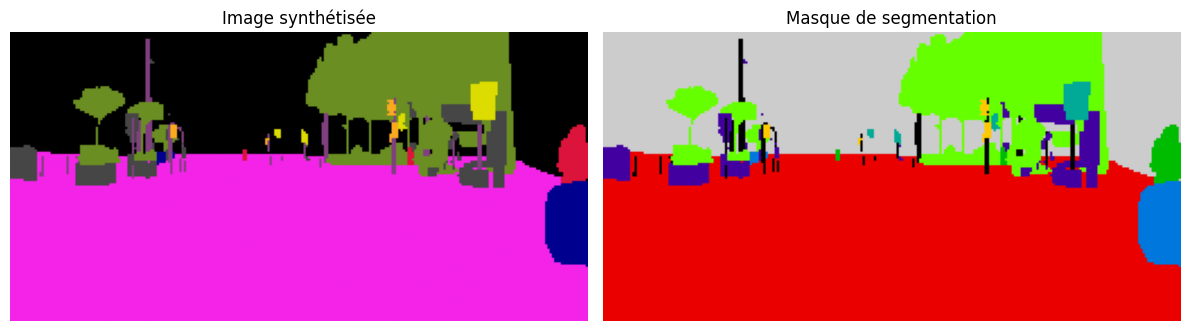

Modèle créé: UNet léger avec 231,881 paramètres
Epoch 1/10


c:\Users\creus\OneDrive\Bureau\IA\8e projet\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8298 - loss: 0.6156

150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 467ms/step - accuracy: 0.8304 - loss: 0.6135 - val_accuracy: 0.9747 - val_loss: 0.0814 - learning_rate: 0.0010
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9779 - loss: 0.0703

150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 449ms/step - accuracy: 0.9779 - loss: 0.0702 - val_accuracy: 0.9890 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9892 - loss: 0.0359

150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 476ms/step - accuracy: 0.9892 - loss: 0.0358 - val_accuracy: 0.9946 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9942 - loss: 0.0200

150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 470ms/step - accuracy: 0.9942 - loss: 0.0199 - val_accuracy: 0.9969 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 5/10
  2/150 ━━━━━━━━━━━━━━━━━━━━ 1:03 428ms/step - accuracy: 0.9971 - loss: 0.0102

c:\Users\creus\OneDrive\Bureau\IA\8e projet\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9970 - loss: 0.0112 - val_accuracy: 0.9967 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 6/10
 63/150 ━━━━━━━━━━━━━━━━━━━━ 41s 475ms/step - accuracy: 0.9965 - loss: 0.0127

In [ ]:
def main():
    # Paramètres
    img_height = 512
    img_width = 1024
    batch_size = 4
    epochs = 10
    
    # Entraîner le modèle avec paramètres optimisés
    model, history = train_model_keras(img_height, img_width, batch_size, epochs)
    
    # Sauvegarder le modèle final
    model.save('final_model_keras_light.h5')
    print("Modèle sauvegardé avec succès.")

if __name__ == "__main__":
    main()